In [15]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,10)
np.random.seed(1234)

## Simulated annealing
 We can also use our Monte Carlo to optimize a rough (nonconvex, with many local minima) function. 
In this case we aim to optimize the Hamiltonian $H$. In order to do so, we introduce a fictitious temperature parameter $\beta$ and we sample from the distribution 
\begin{equation}
    P_\beta(s)=\frac{1}{Z}e^{-\beta H(s)}
\end{equation}
Notice that if we push $\beta\to\infty$, $P_\beta$ becomes concentrated on the minimum of the Hamiltonian.  Morevoer when $β\to\infty $ Metropolis only accepts moves that decrease the Hamiltonian. Indeed $P_{acc}(s^{(t)},s')=\min\{1, \exp[-\beta(H(s')-H(s^{(t)}))]\}\xrightarrow{\beta\to\infty}\Theta(H(s^{(t)})-H(s'))$.
However if we used directly $\beta=\infty$ the Monte Carlo would turn into a greedy algorithm and it would not explore the energy landscape.

Conversely, when $\beta\to0$ the measure $e^{-\beta H}$ becomes uniform so the Monte Carlo just performs a random walk, without taking into account the energy of the configurations.

Simulated annealing is an optimization procedure that tries to get the best of both worlds. We change $\beta=\beta^t$ through the evolution. We start from a small value so the algorithm can explore the landscape, and gradually increase it towards $\infty$, so that the MC is more and more biased towards low energy configurations.

The way we go from low to high $\beta$ is called the annealing schedule.

Since in this case the Hamiltonian is proportional to the logarithm of the posterior minimizing the Hamiltonian is equivalent to maximizing the posterior. It can be proved that for $T\to\infty$ (and a reasonable annealing schedule) the final configuration found by simulated annealing will be the MAP estimator.



Implement simulated annealing by running a Monte Carlo simulation starting from a random configuration and an annealing schedule $\beta^t=\frac{1}{1-t/T}$. Run your simulation for $T=10^4$ steps.

Plot the energy and the overlap as a function of time

In [16]:
# setting parameters
N=128 #number of spins
Delta=0.5 #noise variance

In [17]:
# generating the planted signal (or ground truth)
s_star=2*np.random.binomial(n=1,p=0.5,size=[N])-1
s_star[:10]

array([-1,  1, -1,  1,  1, -1, -1,  1,  1,  1])

In [18]:
# Generate the data Y
W=1/np.sqrt(2)*np.random.normal(loc=0,scale=1,size=[N,N])
W=W+W.T 

Y=np.einsum('i,j->ij',s_star,s_star)/(np.sqrt(N))+np.sqrt(Delta)*W

for i in range(N):
    Y[i,i]=0

In [20]:
Y[:5, :5]

array([[ 0.        , -0.74408329, -0.71429469,  0.27905416,  0.65937468],
       [-0.74408329,  0.        , -0.86030974,  0.21526939,  1.16133939],
       [-0.71429469, -0.86030974,  0.        , -0.71110133, -0.62030802],
       [ 0.27905416,  0.21526939, -0.71110133,  0.        , -0.75220183],
       [ 0.65937468,  1.16133939, -0.62030802, -0.75220183,  0.        ]])

In [5]:
def energy_difference(s,i,Y,Delta): 
    return 2*s[i]*np.einsum("k,k->",Y[i],s)/(np.sqrt(Y.shape[0])*Delta)

In [6]:
s0=2*np.random.binomial(n=1,p=0.5,size=[N])-1

overlaps=[]  
energies=[-np.einsum('ij,i,j->',Y,s0,s0)/(2*np.sqrt(N)*Delta)]
state_history=[np.copy(s0)]


T=10000
s=np.copy(s0)
for t in range(T):
    beta=1/(1-t/T)
    i=np.random.randint(low=0,high=N) #returns an uniformly distributed integer between 0 and N-1 both included.
    delta_H=energy_difference(s,i,Y,Delta)
    prob_accept=min([1,np.exp(-beta*delta_H)])

    if (np.random.rand()<prob_accept):
        s[i]=-s[i]; #if accepted flip the spin
        energies.append(energies[-1]+delta_H)
    else:
        energies.append(energies[-1])

    overlaps.append(np.mean(s*s_star))
    state_history.append(np.copy(s))


Text(0, 0.5, 'overlap')

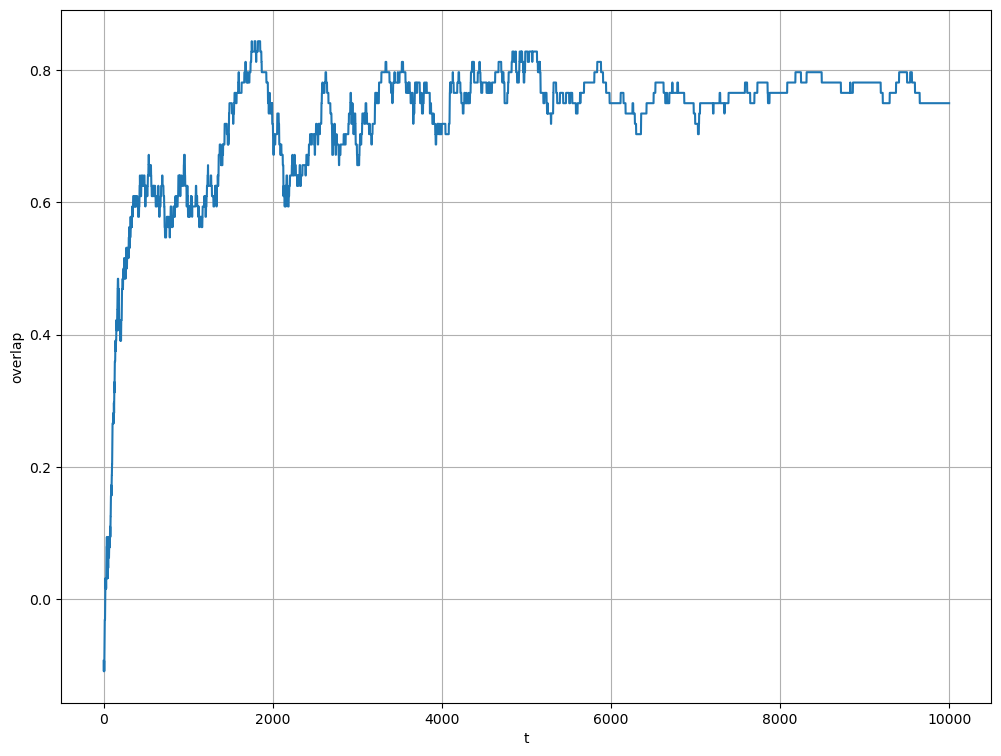

In [7]:
plt.figure(figsize=(12,9))
plt.plot(overlaps)
plt.grid()
plt.xlabel('t')
plt.ylabel('overlap')


Text(0, 0.5, 'energy')

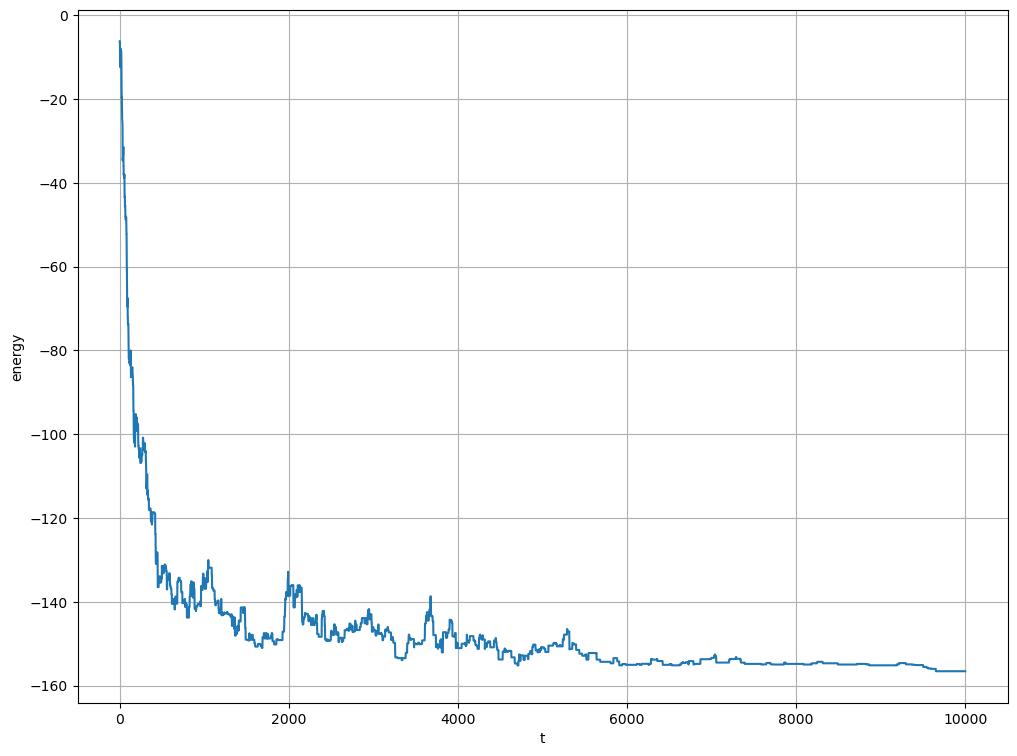

In [8]:
plt.figure(figsize=(12,9))
plt.plot(energies)
plt.grid()
plt.xlabel('t')
plt.ylabel('energy')

## Gibbs Sampling

In this part we extend the model studied in the previous exercise sessions to three possible spin values, namely $S_i\in\{1,-1,0\}$. We assume that $P(S_i=1)=P(S_i=-1)=\rho/2$, and $P(S_i=0) = 1-\rho$.

Following the same approach as in the 2-valued case, generate $s^*$ and $Y$.

In [26]:
np.random.seed(1234)
N=128 #number of spins
Delta=0.1 #noise variance
rho = 0.7

#### generate s_star
s_star=np.random.choice([1,-1,0],N,p=[rho/2,rho/2,1-rho])
s_star

array([ 1, -1, -1,  0,  0,  1,  1,  0,  0,  0, -1, -1, -1,  0, -1, -1, -1,
        1,  0,  0, -1, -1,  1, -1,  0, -1, -1,  0,  1, -1,  0, -1,  0,  1,
        0,  0,  1,  0, -1,  0,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,
       -1, -1,  1, -1,  0,  0,  0,  0,  0,  1, -1, -1,  1, -1,  1, -1,  0,
        1,  1,  0, -1, -1,  1,  1,  0, -1, -1,  1,  1, -1, -1,  0, -1,  0,
        1,  0,  0, -1, -1,  1, -1, -1,  0, -1, -1, -1,  0,  1, -1,  0,  0,
        0, -1,  0,  1,  1, -1,  1,  0,  1,  1, -1,  0,  0,  1,  1,  1,  0,
        0,  0,  0,  0, -1,  1,  1,  1, -1])

In [27]:
# Generate the data Y
W=1/np.sqrt(2)*np.random.normal(loc=0,scale=1,size=[N,N])
W=W+W.T #symmetrizing the noise

Y=np.einsum('i,j->ij',s_star,s_star)/(np.sqrt(N))+np.sqrt(Delta)*W
#Tip check out the function np.einsum : it's the most versatile way to do all the matrix/vector operations!

for i in range(N):
    Y[i,i]=0

In [30]:
Y[:5, :5]

array([[ 0.        , -0.38162404, -0.44735911,  0.16432529,  0.33440979],
       [-0.38162404,  0.        , -0.25682539,  0.05674293,  0.47983829],
       [-0.44735911, -0.25682539,  0.        , -0.27848571, -0.23788171],
       [ 0.16432529,  0.05674293, -0.27848571,  0.        , -0.37592336],
       [ 0.33440979,  0.47983829, -0.23788171, -0.37592336,  0.        ]])

We know study an alternative MCMC approach: Gibbs sampling. We start by writing the posterior:

\begin{equation}
P(S) = \frac{1}{Z}\prod_{i=1}^N\left(\frac{\rho}{2}\delta_{S_i,1}+\frac{\rho}{2}\delta_{S_i,-1}+(1-\rho)\delta_{S_i,0}\right)\prod_{i<j}e^{-\frac{1}{2\Delta}\left(Y_{ij}-\frac{S_iS_j}{\sqrt{N}}\right)^2}
\end{equation}

Gibbs sampling works as follows: given the configuration $\{S_i\}$, we pick one variable $S_k$, and sample $S_k$ from the conditional probability $P(S_k\vert\{S_i\}_{i\neq{k}})$, while keeping the values of the other variables fixed. In this case the conditional probability reads:

\begin{equation}
P(S_k\vert\{S_i\}_{i\neq{k}})=\frac{1}{Z'}\left(\frac{\rho}{2}\delta_{S_k,1}+\frac{\rho}{2}\delta_{S_k,-1}+(1-\rho)\delta_{S_k,0}\right)e^{-\frac{1}{2\Delta{N}}S^2_k\sum_{j\neq{k}}S^2_j+\frac{1}{\Delta\sqrt{N}}S_k\sum_{j=1}^NY_{kj}S_j}
\end{equation}

By introducing the variables $h_k = \frac{1}{\sqrt{N}}\sum_{j=1}^NY_{kj}S_j$ and $h'_k=\frac{1}{N}\sum_{j\neq{k}}S_j^2$, we can rewrite the conditional probability as:

\begin{equation}
P(S_k\vert\{S_i\}_{i\neq{k}})=\frac{1}{Z'}\left(\frac{\rho}{2}\delta_{S_k,1}+\frac{\rho}{2}\delta_{S_k,-1}+(1-\rho)\delta_{S_k,0}\right)e^{-\frac{1}{2\Delta}S^2_kh'_k+\frac{1}{\Delta}S_kh_k}
\end{equation}

where the normalization factor $Z'$ is given by:

\begin{equation}
Z' = (1-\rho) + \frac{\rho}{2}e^{-\frac{1}{2\Delta}h'_k+\frac{1}{\Delta}h_k}  + \frac{\rho}{2}e^{-\frac{1}{2\Delta}h'_k-\frac{1}{\Delta}h_k} 
\end{equation}

Then, the update rule of Gibbs sampling becomes:

\begin{equation}
\begin{split}
&S_k = +1  \hspace{0.3cm}\text{w.p.}\hspace{0.3cm} p_1 = \frac{\frac{\rho}{2}e^{-\frac{1}{2\Delta}h'_k+\frac{1}{\Delta}h_k}}{Z'}\\
&S_k = -1  \hspace{0.3cm}\text{w.p.}\hspace{0.3cm} p_{-1} = \frac{\frac{\rho}{2}e^{-\frac{1}{2\Delta}h'_k-\frac{1}{\Delta}h_k}}{Z'}\\
&S_k = 0  \hspace{0.3cm}\text{w.p.}\hspace{0.3cm} p_{0} = \frac{(1-\rho)}{Z'}\\
\end{split}
\end{equation}

Implement the following three functions: 1) a function returning $h_k$ given $Y$ and $S$; 2) a function returning $h'_k$ given $S$; 3) a function returning $p_1,p_{-1},p_{0}$ as defined above, given $h_k$, $h'_k$, $\Delta$ and $\rho$.

In [11]:
## implement the three functions

def field_1(Y,s):
    N=len(s)
    return (1/(np.sqrt(N)))*np.einsum('kj,j->k',Y,s)


def field_2(s):
    N = len(s)
    indices = np.arange(N)
    temp = np.zeros(N)
    for i in range(N):
        temp[i] = np.sum(np.delete(s,indices[i])**2)/N
    return temp    

def get_probs(h1,h2,Delta,rho):
    Z = (1-rho)+(rho/2)*np.exp((-1/(2*Delta))*h2-(1/(Delta))*h1) + (rho/2)*np.exp((-1/(2*Delta))*h2+(1/(Delta))*h1)
    p1 = ((rho/2)*np.exp((-1/(2*Delta))*h2+(1/(Delta))*h1))/Z
    p2 = ((rho/2)*np.exp((-1/(2*Delta))*h2-(1/(Delta))*h1))/Z
    p3 = (1-rho)/Z
    return p1,p2,p3
    

Now, implement and run Gibbs sampling. Save the overlaps and plot them as a function of the iterations. 

In [32]:
rho_zero=rho
s_0=np.random.choice([1,-1,0],N,p=[rho_zero/2,rho_zero/2,1-rho_zero])
T=10
T_therm=3000
s = np.copy(s_0)

overlaps = [np.max([np.sum(s == s_star)/len(s),np.sum(s == -s_star)/len(s)])]
state_history = [s]
density = [1-np.sum(s==0)/N]

for t in tqdm(range(T)):
    #### chose a variable
    k = np.random.choice(N)
    #### evaluate the fields
    h1 = field_1(Y,s)
    h2 = field_2(s)
    print(h1[k], h2[k])
    #### evaluate the probabilities
    p1,p2,p3 = get_probs(h1[k],h2[k],Delta,rho)
    # print(p1,p2,p3)
    #### sample
    s_k = np.random.choice([1,-1,0], p=[p1,p2,p3])
    #### replace
    s[k] = s_k

    if t>T_therm:
        density.append(1-np.sum(s==0)/N)
        overlaps.append(np.max([np.sum(s == s_star)/len(s),np.sum(s == -s_star)/len(s)]))
        #overlaps.append(np.sum(s == s_star)/len(s))
        state_history.append(np.copy(s))

    
    

100%|██████████| 10/10 [00:00<00:00, 1865.21it/s]

-0.1717595283570554 0.65625
-0.02369416154501753 0.6484375
0.033453170666003895 0.6484375
0.04553686755008585 0.640625
0.16855428366960712 0.640625
-0.20002649690792423 0.6328125
0.05875658901577683 0.6328125
0.050390988819754394 0.6328125
0.38649091188090107 0.6328125
0.12199579736657161 0.625


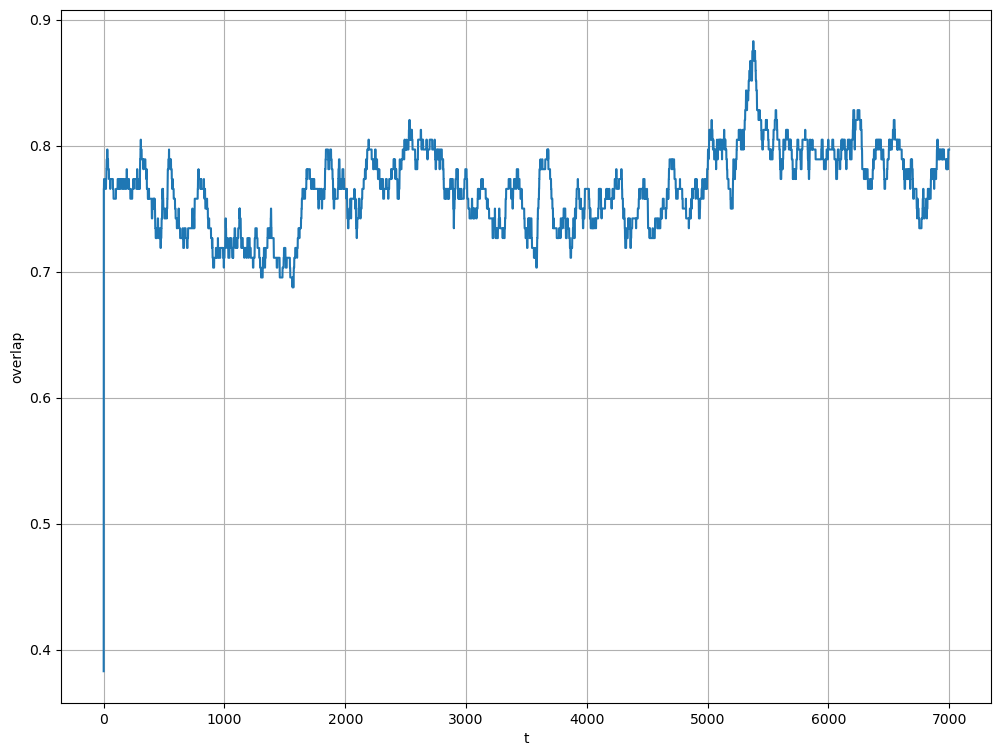

In [13]:
plt.figure(figsize=(12,9))
plt.plot(overlaps)
plt.xlabel("t")
plt.ylabel("overlap")
plt.grid()

## Gibbs Sampling with Expectation Maximization

Let's generate some data in the same way as we did before.

In [14]:
N=128 #number of spins
Delta=0.1#noise variance
rho_true = 0.7
# generating the planted signal (or ground truth)
s_star=np.random.choice([1,-1,0],N,p=[rho_true/2,rho_true/2,1-rho_true])

# Generate the data Y
W=1/np.sqrt(2)*np.random.normal(loc=0,scale=1,size=[N,N])
W=W+W.T #symmetrizing the noise

Y=np.einsum('i,j->ij',s_star,s_star)/(np.sqrt(N))+np.sqrt(Delta)*W

for i in range(N):
    Y[i,i]=0

Our goal is now to infer $\rho$ from data. 

For the considered problem, it can be easily proved (see lecture) that to perform EM we need to iterate the fixed point equation:
\begin{equation}
\begin{split}
&\rho^{(u+1)}=\frac{1}{N}\sum_i^N \left(\mu_i(S_i=1|Y,\rho^{(u)})+\mu_i(S_i=-1|Y,\rho^{(u)})\right)
\end{split}
\end{equation}



Implement expectation maximization by filling the code block provided below: you should have an external cycle over $u$( the iteration index of EM) and an internal cycle to run Gibbs sampling at each step $u$.

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 885.77it/s]


0.5302578125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 898.61it/s]


0.6358694196428571


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 897.54it/s]


0.6796763392857142


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 890.29it/s]


0.7011339285714285


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 882.74it/s]


0.7110669642857143


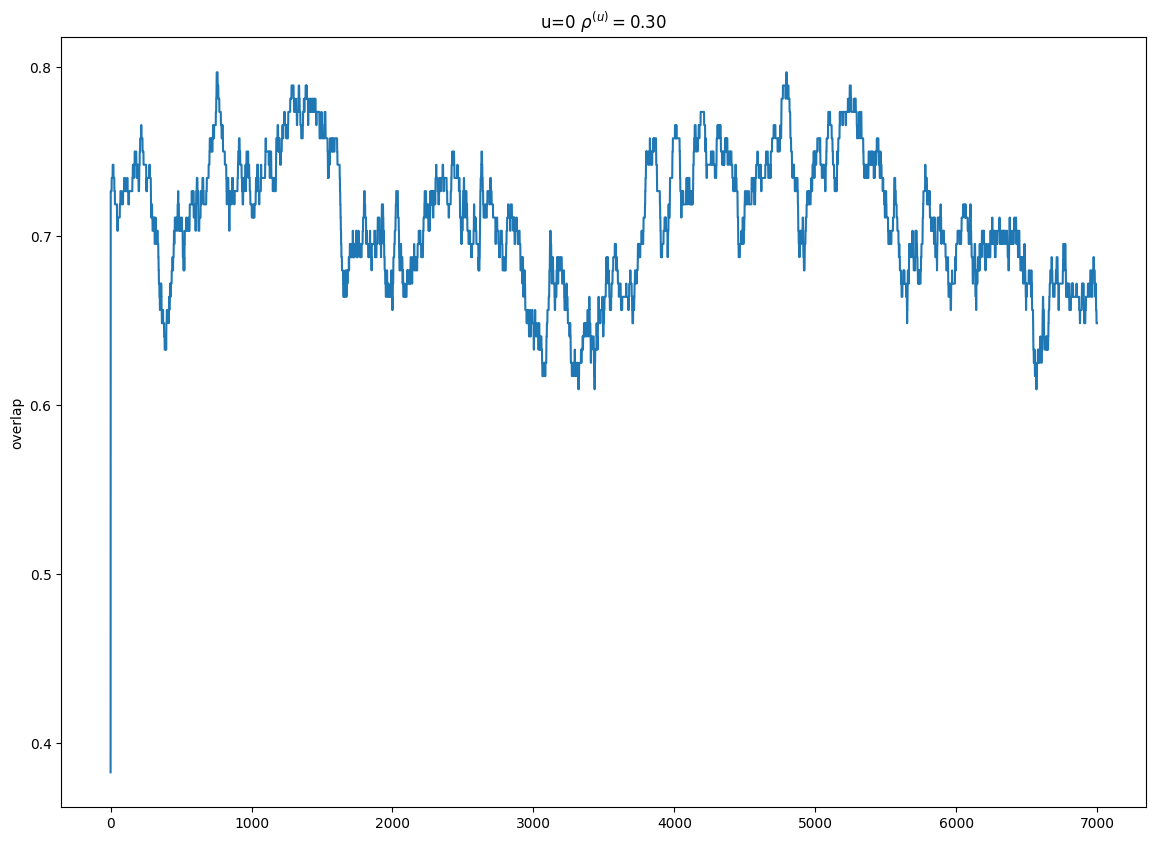

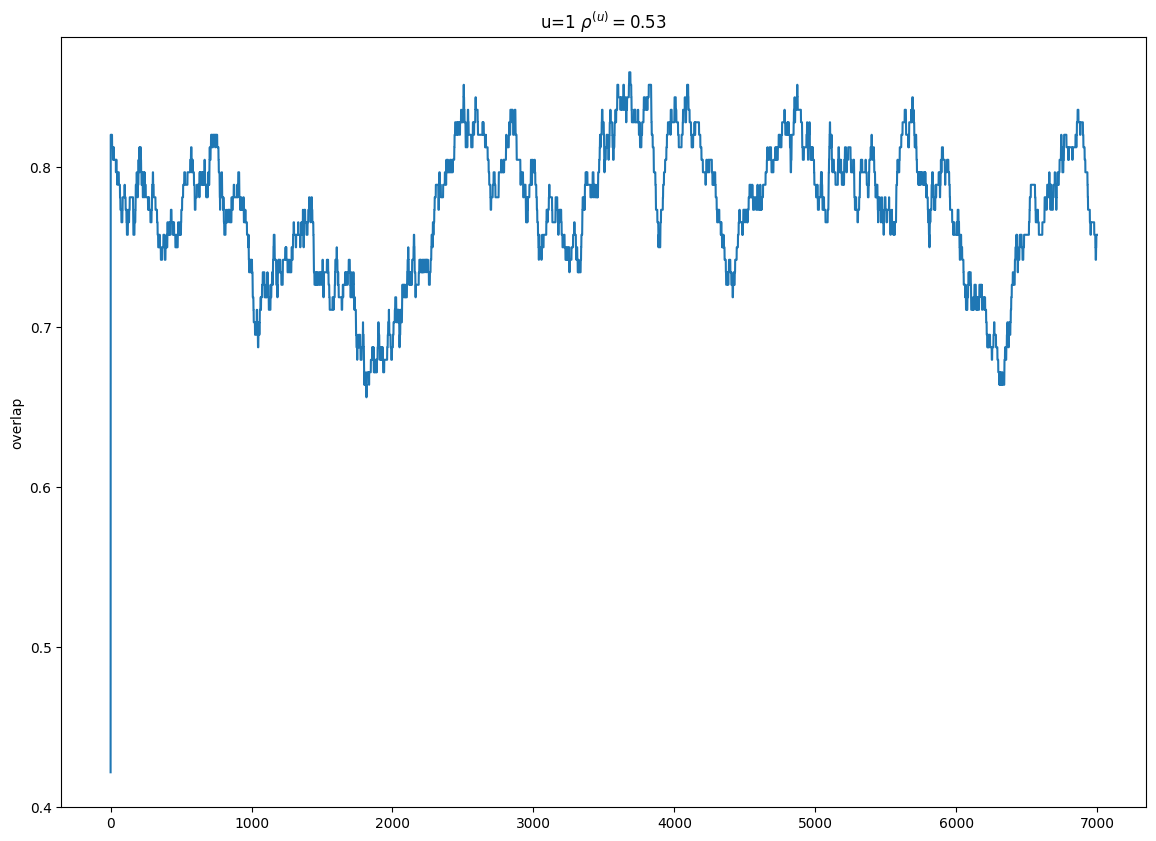

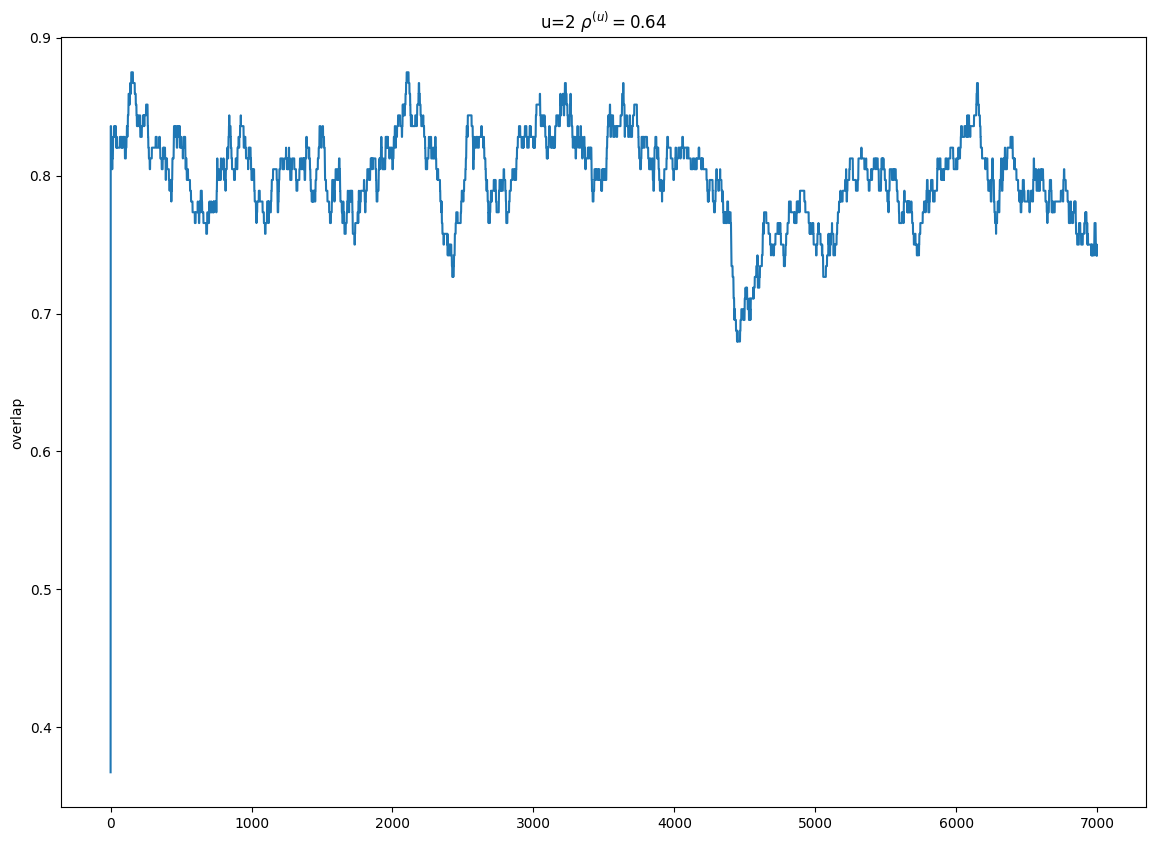

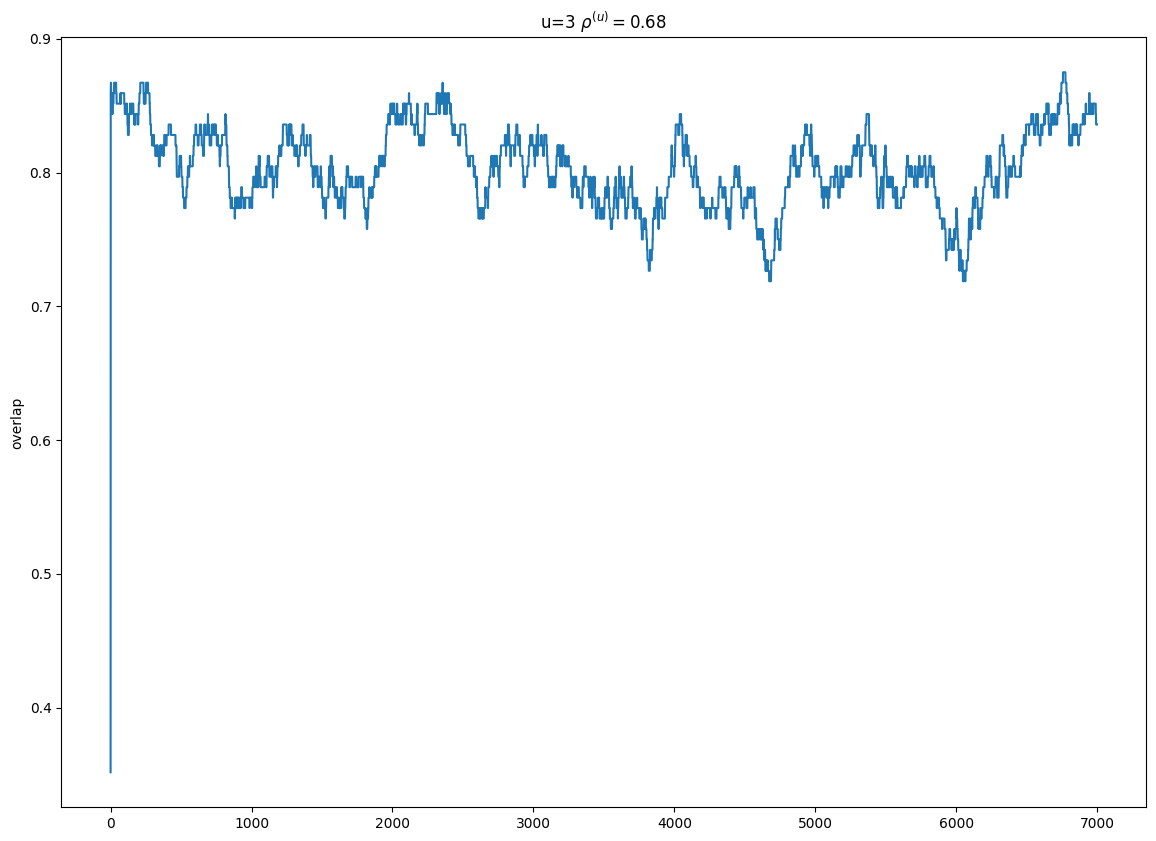

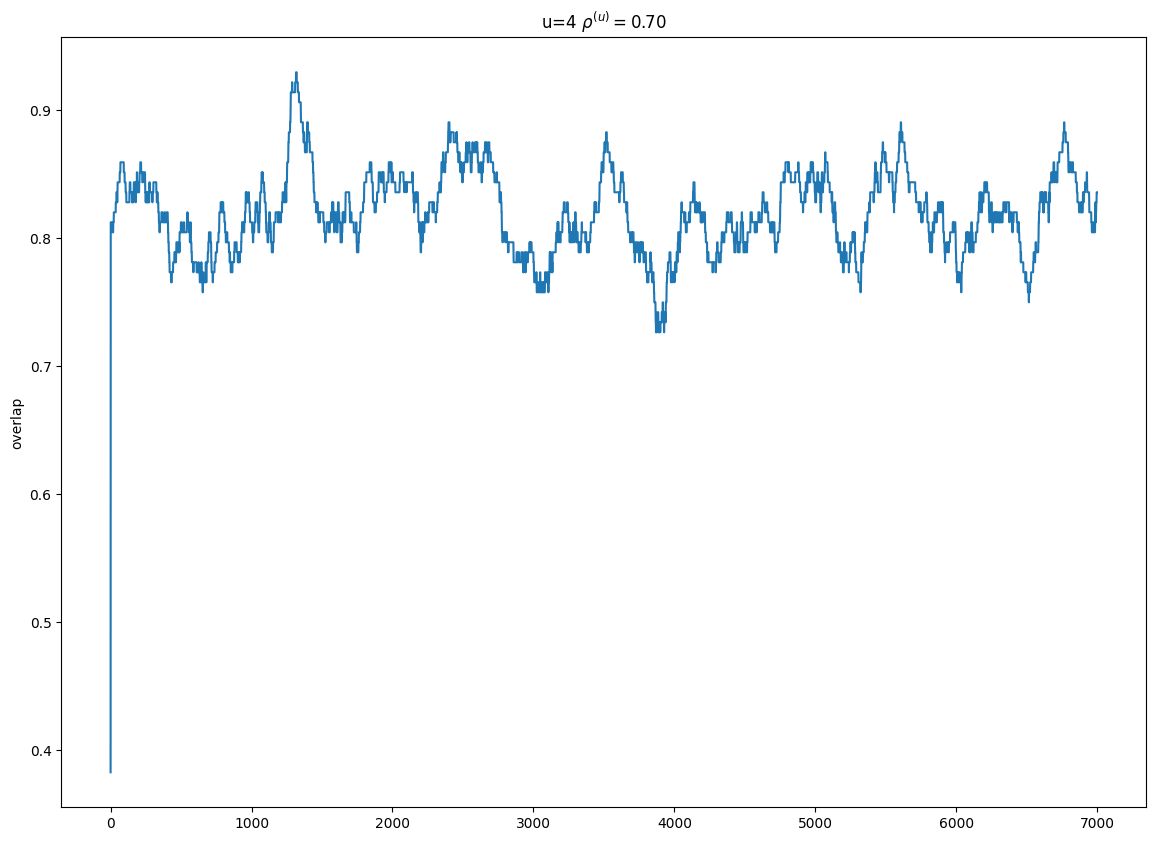

In [15]:
np.random.seed(1234)
T=10000 
T_therm=3000
U=5 #number of EM iterations
rho=0.3 #initial value of rho
rho_history=[rho] #keeping track of values of rho.

for u in range(U):

    s_0=np.random.choice([1,-1,0],N,p=[rho/2,rho/2,1-rho]) 
    s=np.copy(s_0)
    p_1=0  #right hand side of the update equation for rho
    overlaps=[]
    overlaps.append(np.max([np.sum(s == s_star)/len(s),np.sum(s == -s_star)/len(s)]))

    for t in tqdm(range(T)):
        k = np.random.choice(N)
        #### evaluate the fields
        h1 = field_1(Y,s)
        h2 = field_2(s)
        #### evaluate the probabilities
        p1,p2,p3 = get_probs(h1[k],h2[k],Delta,rho)
        #### sample
        s_k = np.random.choice([1,-1,0], p=[p1,p2,p3])
        #### replace
        s[k] = s_k
        if(t>T_therm):
            p_1+=np.mean(np.abs(s)==1) #### average over N
            overlaps.append(np.max([np.sum(s == s_star)/len(s),np.sum(s == -s_star)/len(s)]))
    
    plt.figure()
    plt.title(r"u=%d $\rho^{(u)}=%.2f$"%(u,rho))
    plt.ylabel('overlap')
    plt.plot(overlaps)
    rho=p_1/(T-T_therm) #### average over posterior samples
    rho_history.append(rho)
    print(rho)


Text(0, 0.5, '$\\rho$')

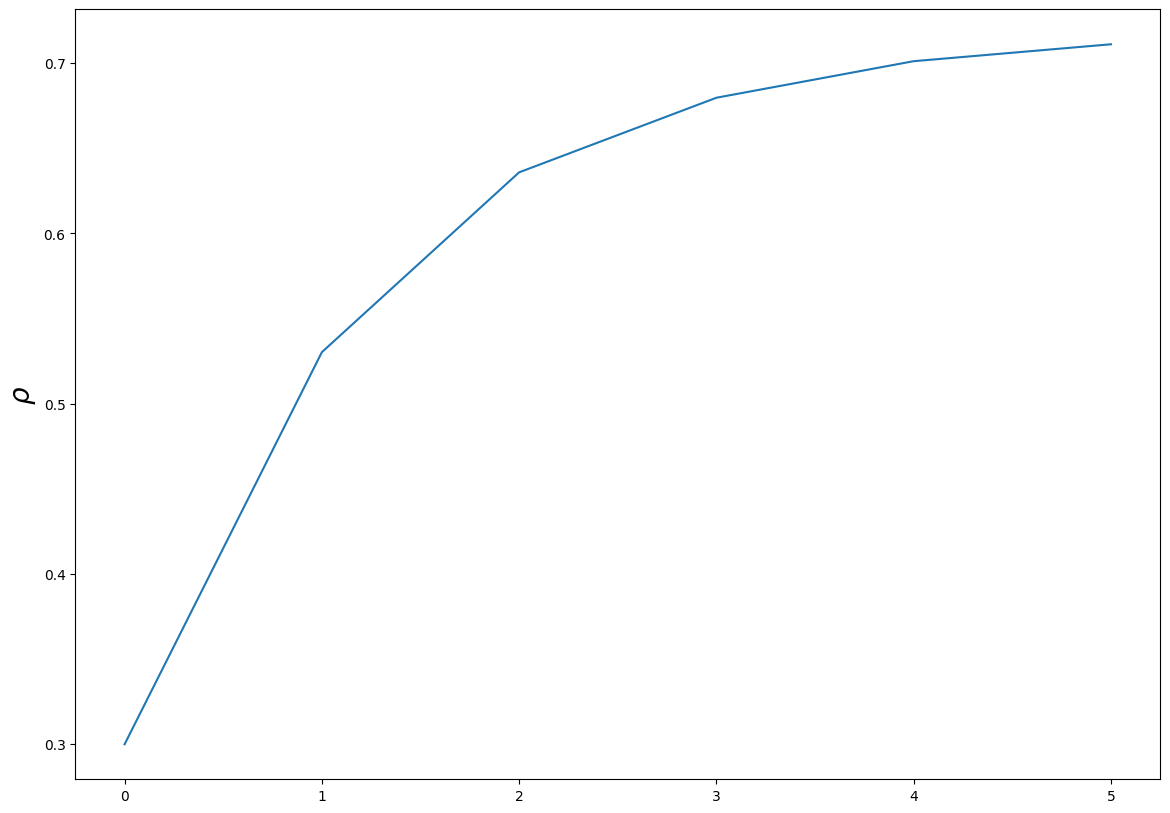

In [16]:
plt.plot(rho_history)
plt.ylabel(r'$\rho$',fontsize=20)